# Exploratory Data Analysis by Scraping Sofascore Argentina's Data from the CONMEBOL Copa América 2024

## 1. Aims, objectives and background

### 1.1. Introduction
Argentina's soccer team has grown to become arguably the best international team in the world and in history. The goal of this project is to analyze Argentina's national soccer team data on their matches across CONMEBOL Copa America 2024. As a Data Science enthusiast, it is a challenge and a great desire to work with sports data in order to learn Data skills; being soccer my favorite sport, I think it is a great way of working with Data Science Fundamentals as data gathering, visualization and analysis. Therefore, this project will explore the statistics from the 2024 Copa America champion: Argentina.
This project will scope, analyze, prepare, plot and seek data to explain the findings from the analysis.

### 1.2. Aims and objectives
Here are a few questions that this project has sought to answer:
 * General Performance
     * What was the average amount of goals per game in the cup for Argentina?
     * How did the ball possesion variate across the tournament?
     * How efficient was Argentina in converting shots to goals?
     * How does the match statistics change from groups phase with eliminatory phase?
     * Which were the differences in statistics between won, lost and tied matches?

 * Specific Analysis
    * How effective was Argentina's defense in terms of shots and goals against?
    * Which players where the more effective in terms of goals, assistance, shots and expected goals?
    * expected goals vs real goals?

 * Shotmap Analysis
    * From which positions in the field were the majority of shots taken?
    * What was the conversion rate of shots into goals from different areas of the field?
    * How were the shots distributed in terms of xG and xGOT (expected goals on target)?

### 1.3. Steps of the project
1. Obtain the matches' data by webscraping Sofascore with an API url
2. Preprocess data and engineer additional features for analysis
3. Exploratory and statistical data analysis
4. Conclusions


### 1.4. Dataset
#### Data selection
As this project is particularly focused on sports statistics and visualizations, I found that Sofascore would be suitable for this purpose.


In [1]:
import pandas as pd
import numpy as np
import csv

import ast

# Scraping libraries
import requests
from scraping_functions import *
import logging

# Data visualizatoin libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch

# Statistic functions libraries
from scipy import stats
import math
from scipy.stats import pearsonr

## 2. Data creation with Sofascore API url
Each match's site has its own URL for scraping statistics and shotmap information, so several URLs were needed to create different files for storing the data. Some scraping functions are required first to generate files and dataframes with the desired information.


In [2]:
FULL_MATCH = 'Full Match'
FIRST_HALF = 'First Half'
SECOND_HALF = 'Second Half'
EXTRA_TIME_1 = 'Extra Time 1'
EXTRA_TIME_2 = 'Extra Time 2'


def write_statistics_to_csv(writer, period, groups):
    # writes json data into csv file
    for group in groups:
        group_name = group['groupName']
        for item in group['statisticsItems']:
            writer.writerow([period, group_name, item['name'], item['home'], item['away']])


def extract_stats(url, filename):
    """ 
    Get match statistics: Load stats into csv files
    
    Params:
    url: the specific match URL provided from Sofascore to scrape data.
    filename: the file name we want to give to our csv

    Returns:
    Error handling through try/except blocks
    """ 
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as error:
        logging.error(f"There has been an error while requesting to {url}: {error}")
        return

    try:
        data = response.json()
        match_stats = data['statistics']
    except (ValueError, KeyError) as error:
        logging.error(f"There has been an error while processing JSON data: {error}")
        return

    if not match_stats:
        logging.warning(f"No statistics found in the gathered data from {url}")
        return

    try:
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Period', 'Group', 'Statistic', 'Home', 'Away'])

            if len(match_stats) >= 3:
                write_statistics_to_csv(writer, FULL_MATCH, match_stats[0]['groups'])
                write_statistics_to_csv(writer, FIRST_HALF, match_stats[1]['groups'])
                write_statistics_to_csv(writer, SECOND_HALF, match_stats[2]['groups'])

            if len(match_stats) == 5:
                write_statistics_to_csv(writer, EXTRA_TIME_1, match_stats[3]['groups'])
                write_statistics_to_csv(writer, EXTRA_TIME_2, match_stats[4]['groups'])

            logging.info(f"Statistics written succesfully in {filename}")

    except IOError as error:
        logging.error(f"Could not write in file {filename}: {error}")


def extract_shotmap(url, filename):
    """ 
    Get shotmap stats: Load stats into csv files
    Params:

    url: the specific match URL provided from Sofascore to scrape data.
    filename: the file name we want to give to our csv

    Returns:
    Error handling messages through try/except blocks
    """ 
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as error:
        logging.error(f"There has been an error while requesting {url}: {error}")
        return

    try:
        data = response.json()
        shotmap = data['shotmap']
    except (ValueError, KeyError) as error:
        logging.error(f"There has been an error while processing JSON data: {error}")
        return

    if not shotmap:
        logging.warning(f"Shotmap data was not found in {url}")
        return

    try:
        with open(filename, mode='w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Name', 'Position', 'Outcome', 'Situation', 'Player Coordinates', 'Body Part',
                             'Shot Location', 'Shot Coordinates', 'Expected Goal (xG)',
                             'Expected Goal on Target (xGOT)'])

            for shot in shotmap:
                player_name = shot['player'].get('name', '')
                player_position = shot['player'].get('position', '')                                
                outcome = shot.get('shotType', '')
                situation = shot.get('situation', '')
                player_coordinates = shot.get('playerCoordinates', {})
                body_part = shot.get('bodyPart', '')
                shot_location = shot.get('goalMouthLocation', '')
                shot_coordinates = shot.get('goalMouthCoordinates', {})
                xg = shot.get('xg', 0)
                xgot = shot.get('xgot', 0)

                writer.writerow([player_name, player_position, jersey_number, outcome, situation, player_coordinates,
                                 body_part, shot_location, shot_coordinates, xg, xgot])

            logging.info(f"Shotmap data written succesfully in {filename}")
    except IOError as error:
        logging.error(f"Error while writing in {filename}: {error}")


### Turn CSV files into Pandas df

In [3]:
# Argentina vs Canada (2-0) - Groups phase 
match1_stats = pd.read_csv('match1_stats.csv')
match1_shotmap = pd.read_csv('match1_shotmap.csv')

# Chile vs Argentina (0-1) - Groups phase
match2_stats = pd.read_csv('match2_stats.csv')
match2_shotmap = pd.read_csv('match2_shotmap.csv')

# Argentina vs Peru (2-0) - Groups phase
match3_stats = pd.read_csv('match3_stats.csv')
match3_shotmap = pd.read_csv('match3_shotmap.csv')

# Argentina vs Ecuador (1-1) - Penalties (4-2) - Quarter Finals
match4_stats = pd.read_csv('match4_stats.csv')
match4_shotmap = pd.read_csv('match4_shotmap.csv')

# Argentina vs Canada (2-0) - Semifinals
match5_stats = pd.read_csv('match5_stats.csv')
match5_shotmap = pd.read_csv('match5_shotmap.csv')

# Argentina vs Colombia (1-0) - Final
match6_stats = pd.read_csv('match6_stats.csv')
match6_shotmap = pd.read_csv('match6_shotmap.csv')

shotmaps_tup = (match1_shotmap, match2_shotmap, match3_shotmap, match4_shotmap, match5_shotmap, match6_shotmap)

### Get matches stats and shotmaps
Using the functions defines above, now we are going to obtain the match statistics for the 6 matches in scope.

In [4]:
from scraping_functions import *
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def main():
    
    data_dicts = [
        {
            # Argentina vs Canada (2 - 0) - Groups phase
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886373/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886373/shotmap',
            'stats_filename': 'match1_stats.csv',
            'shotmap_filename': 'match1_shotmap.csv'
        },
        {
            # Chile vs Argentina (0 - 1) - Groups phase
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886369/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886369/shotmap',
            'stats_filename': 'match2_stats.csv',
            'shotmap_filename': 'match2_shotmap.csv'
        },
        {
            # Argentina vs Peru (2 - 0) - Groups phase
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886396/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886396/shotmap',
            'stats_filename': 'match3_stats.csv',
            'shotmap_filename': 'match3_shotmap.csv'
        },
        {
            # Argentina vs Ecuador (1 - 1)(Penalties: 4 - 2) - Quarter finals
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886594/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886594/shotmap',
            'stats_filename': 'match4_stats.csv',
            'shotmap_filename': 'match4_shotmap.csv'
        },
        {
            # Argentina vs Canada (2 - 0) - Semi finals
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886259/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886259/shotmap',
            'stats_filename': 'match5_stats.csv',
            'shotmap_filename': 'match5_shotmap.csv'
        },
        {
            # Argentina vs Colombia (1 - 0) - Final
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886600/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886600/shotmap',
            'stats_filename': 'match6_stats.csv',
            'shotmap_filename': 'match6_shotmap.csv'
        }
    ]

    try:
        for match_data in data_dicts:
            extract_stats(match_data['stats_url'], match_data['stats_filename'])
            extract_shotmap(match_data['shotmap_url'], match_data['shotmap_filename'])
    except Exception as error:
        logging.error(f"An unexpected error ocurred: {error}")


if __name__ == "__main__":
    main()


2024-09-20 14:37:31,415 - INFO - Statistics written succesfully in match1_stats.csv
2024-09-20 14:37:32,001 - INFO - Shotmap data written succesfully in match1_shotmap.csv
2024-09-20 14:37:32,327 - INFO - Statistics written succesfully in match2_stats.csv
2024-09-20 14:37:32,770 - INFO - Shotmap data written succesfully in match2_shotmap.csv
2024-09-20 14:37:33,095 - INFO - Statistics written succesfully in match3_stats.csv
2024-09-20 14:37:33,409 - INFO - Shotmap data written succesfully in match3_shotmap.csv
2024-09-20 14:37:33,718 - INFO - Statistics written succesfully in match4_stats.csv
2024-09-20 14:37:34,697 - INFO - Shotmap data written succesfully in match4_shotmap.csv
2024-09-20 14:37:35,790 - INFO - Statistics written succesfully in match5_stats.csv
2024-09-20 14:37:36,104 - INFO - Shotmap data written succesfully in match5_shotmap.csv
2024-09-20 14:37:36,411 - INFO - Statistics written succesfully in match6_stats.csv
2024-09-20 14:37:36,717 - INFO - Shotmap data written su

### Exploring data
Now I can print out the data and take a look at the stats and shotmaps overview.

In [5]:
match1_stats.head()

,Period,Group,Statistic,Home,Away
0,Full Match,Match overview,Ball possession,64%,36%
1,Full Match,Match overview,Expected goals,3.02,1.16
2,Full Match,Match overview,Big chances,9,2
3,Full Match,Match overview,Total shots,19,10
4,Full Match,Match overview,Goalkeeper saves,2,6


In [6]:
match1_shotmap.head()

,Name,Position,Outcome,Situation,Player Coordinates,Body Part,Shot Location,Shot Coordinates,Expected Goal (xG),Expected Goal on Target (xGOT)
0,Lionel Messi,F,save,free-kick,"{'x': 23.5, 'y': 57.3, 'z': 0}",left-foot,high-right,"{'x': 0, 'y': 47.2, 'z': 24.7}",0.071207,0.2324
1,Jacob Shaffelburg,M,save,set-piece,"{'x': 23.3, 'y': 68.7, 'z': 0}",left-foot,low-centre,"{'x': 0, 'y': 48.9, 'z': 2.5}",0.023184,0.0416
2,Lautaro Martínez,F,goal,assisted,"{'x': 11.1, 'y': 57.1, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 49, 'z': 3.8}",0.594084,0.6147
3,Nicolás Otamendi,D,miss,set-piece,"{'x': 3.3, 'y': 49.8, 'z': 0}",left-foot,high,"{'x': 0, 'y': 50.4, 'z': 62.5}",0.345816,0.0000
4,Lautaro Martínez,F,save,assisted,"{'x': 15.7, 'y': 43.2, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 49.7, 'z': 1.9}",0.401235,0.1469


### Concatenate files

In [7]:
stats_dfs = [match1_stats, match2_stats, match3_stats, match4_stats, match5_stats, match6_stats]
for i, df in enumerate(stats_dfs, start=1):
    df['Match'] = f'Match {i}'

shotmap_dfs = [match1_shotmap, match2_shotmap, match3_shotmap, match4_shotmap, match5_shotmap, match6_shotmap]
for i, df in enumerate(shotmap_dfs, start=1):
    df['Match'] = f'Match {i}'

all_stats = pd.concat(stats_dfs, ignore_index=True)
all_shotmaps = pd.concat(shotmap_dfs, ignore_index=True)

In [8]:
# create csv files too
all_stats.to_csv('all_stats.csv', index=False)
all_shotmaps.to_csv('all_shotmaps.csv', index=False)

In [9]:
all_stats

,Period,Group,Statistic,Home,Away,Match
0,Full Match,Match overview,Ball possession,64%,36%,Match 1
1,Full Match,Match overview,Expected goals,3.02,1.16,Match 1
2,Full Match,Match overview,Big chances,9,2,Match 1
3,Full Match,Match overview,Total shots,19,10,Match 1
4,Full Match,Match overview,Goalkeeper saves,2,6,Match 1
...,...,...,...,...,...,...
804,Extra Time 2,Defending,Interceptions,2,1,Match 6
805,Extra Time 2,Defending,Recoveries,10,8,Match 6
806,Extra Time 2,Defending,Clearances,9,1,Match 6
807,Extra Time 2,Goalkeeping,Total saves,0,0,Match 6


In [10]:
all_shotmaps

,Name,Position,Outcome,Situation,Player Coordinates,Body Part,Shot Location,Shot Coordinates,Expected Goal (xG),Expected Goal on Target (xGOT),Match
0,Lionel Messi,F,save,free-kick,"{'x': 23.5, 'y': 57.3, 'z': 0}",left-foot,high-right,"{'x': 0, 'y': 47.2, 'z': 24.7}",0.071207,0.2324,Match 1
1,Jacob Shaffelburg,M,save,set-piece,"{'x': 23.3, 'y': 68.7, 'z': 0}",left-foot,low-centre,"{'x': 0, 'y': 48.9, 'z': 2.5}",0.023184,0.0416,Match 1
2,Lautaro Martínez,F,goal,assisted,"{'x': 11.1, 'y': 57.1, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 49, 'z': 3.8}",0.594084,0.6147,Match 1
3,Nicolás Otamendi,D,miss,set-piece,"{'x': 3.3, 'y': 49.8, 'z': 0}",left-foot,high,"{'x': 0, 'y': 50.4, 'z': 62.5}",0.345816,0.0000,Match 1
4,Lautaro Martínez,F,save,assisted,"{'x': 15.7, 'y': 43.2, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 49.7, 'z': 1.9}",0.401235,0.1469,Match 1
...,...,...,...,...,...,...,...,...,...,...,...
143,Lionel Messi,F,save,assisted,"{'x': 13.3, 'y': 45.2, 'z': 0}",left-foot,low-left,"{'x': 0, 'y': 53.1, 'z': 7}",0.180623,0.1711,Match 6
144,Carlos Cuesta,D,save,corner,"{'x': 7, 'y': 48.5, 'z': 0}",head,low-left,"{'x': 0, 'y': 52.2, 'z': 7}",0.102550,0.1155,Match 6
145,Jhon Córdoba,F,post,assisted,"{'x': 13, 'y': 59.3, 'z': 0}",right-foot,left,"{'x': 0, 'y': 55.4, 'z': 13.3}",0.094253,0.0000,Match 6
146,Luis Díaz,F,save,assisted,"{'x': 23.1, 'y': 31.5, 'z': 0}",right-foot,low-left,"{'x': 0, 'y': 53.2, 'z': 2.5}",0.020884,0.1656,Match 6


In [11]:
print(all_stats.dtypes)
print(all_shotmaps.dtypes)

Period       object
Group        object
Statistic    object
Home         object
Away         object
Match        object
dtype: object
Name                               object
Position                           object
Outcome                            object
Situation                          object
Player Coordinates                 object
Body Part                          object
Shot Location                      object
Shot Coordinates                   object
Expected Goal (xG)                float64
Expected Goal on Target (xGOT)    float64
Match                              object
dtype: object


In [12]:
print(all_stats.isnull().any())
print(all_shotmaps.isnull().any())

Period       False
Group        False
Statistic    False
Home         False
Away         False
Match        False
dtype: bool
Name                              False
Position                          False
Outcome                           False
Situation                         False
Player Coordinates                False
Body Part                         False
Shot Location                     False
Shot Coordinates                  False
Expected Goal (xG)                False
Expected Goal on Target (xGOT)    False
Match                             False
dtype: bool


In [13]:
i=1
for df in stats_dfs:
    print(f"Match {i} shape: {df.shape}")
    i+=1

print()
i=1
for df in shotmap_dfs:
    print(f"Shotmap {i} shape: {df.shape}")
    i+=1

Match 1 shape: (122, 6)
Match 2 shape: (122, 6)
Match 3 shape: (121, 6)
Match 4 shape: (121, 6)
Match 5 shape: (122, 6)
Match 6 shape: (201, 6)

Shotmap 1 shape: (29, 11)
Shotmap 2 shape: (25, 11)
Shotmap 3 shape: (18, 11)
Shotmap 4 shape: (26, 11)
Shotmap 5 shape: (20, 11)
Shotmap 6 shape: (30, 11)


In [14]:
print(f"Number of match stats: {all_stats.Statistic.nunique()}\n")
print(f"Match Stats:\n")
for stat in all_stats.Statistic.unique():
    print(stat)

Number of match stats: 45

Match Stats:

Ball possession
Expected goals
Big chances
Total shots
Goalkeeper saves
Corner kicks
Fouls
Passes
Tackles
Free kicks
Yellow cards
Shots on target
Hit woodwork
Shots off target
Blocked shots
Shots inside box
Shots outside box
Big chances scored
Big chances missed
Through balls
Touches in penalty area
Fouled in final third
Offsides
Accurate passes
Throw-ins
Final third entries
Final third phase
Long balls
Crosses
Duels
Dispossessed
Ground duels
Aerial duels
Dribbles
Tackles won
Total tackles
Interceptions
Recoveries
Clearances
Total saves
Goals prevented
High claims
Goal kicks
Errors lead to a shot
Big saves


In [15]:
print(f"Columns in shotmap dataframe: {len(all_shotmaps.columns)}\n")
print(f"Shotmap columns:")
for shotmap in all_shotmaps.columns:
    print(shotmap)

Columns in shotmap dataframe: 11

Shotmap columns:
Name
Position
Outcome
Situation
Player Coordinates
Body Part
Shot Location
Shot Coordinates
Expected Goal (xG)
Expected Goal on Target (xGOT)
Match


## 3. Exploratory Analysis

### Argentina's possession during tournament
With the matches' stats for all games, now we can see how possesion was distributed per game. Some games might have much more ball possession for Argentina, while other games not so much. 

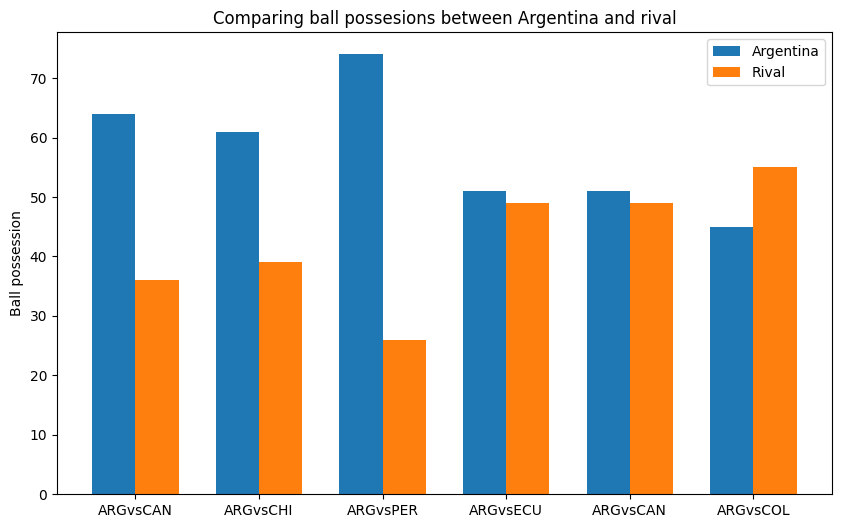

In [16]:
possession_df = all_stats[(all_stats['Statistic'] == 'Ball possession') & (all_stats['Period'] == 'Full Match')].copy()

# Reformatting columns to have numerical values instead of str
possession_df['Home'] = possession_df['Home'].str.replace('%', '').astype(float)
possession_df['Away'] = possession_df['Away'].str.replace('%', '').astype(float)

argentina_possession = possession_df[['Home', 'Away']]

# Swap 'Home' and 'Away' for the second match (where Argentina was named a visitor)
argentina_possession.iloc[1] = argentina_possession.iloc[1][::-1]  

x_values = range(argentina_possession.shape[0])
bar_width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar([x - bar_width/2 for x in x_values], argentina_possession['Home'], width=bar_width, label='Argentina')
bar2 = ax.bar([x + bar_width/2 for x in x_values], argentina_possession['Away'], width=bar_width, label='Rival')

ax.set_ylabel('Ball possession')
ax.set_title('Comparing ball possesions between Argentina and rival')
ax.set_xticks(x_values)
ax.set_xticklabels(['ARGvsCAN', 'ARGvsCHI', 'ARGvsPER', 'ARGvsECU', 'ARGvsCAN', 'ARGvsCOL'])
ax.legend()

plt.show()


In [17]:
mean_possesion = argentina_possession.Home.mean()
median_possession = argentina_possession.Home.median()
std_dev_possession = argentina_possession.Home.std()

print(f"Argentina's average ball possession: {mean_possesion:.1f}%")
print(f"Argentina's median ball possession: {median_possession:.1f}%")
print(f"Standard deviation of Argentina's ball possession: {std_dev_possession:.1f}%")
print(f"Variance of Argentina's ball possession: {std_dev_possession**2:.1f}%")


Argentina's average ball possession: 57.7%
Argentina's median ball possession: 56.0%
Standard deviation of Argentina's ball possession: 10.7%
Variance of Argentina's ball possession: 113.5%


### Possession Analysis

Argentina’s average ball possession during the tournament was **57.7%**, indicating that they generally controlled the game by maintaining possession. However, the **standard deviation of 10.7%** and the corresponding **variance of 113.5** show significant variability across matches.

- **Average Possession (57.7%)**: This suggests Argentina preferred a possession-based style, keeping the ball for a majority of the time.
- **Possession Variability**: The standard deviation indicates that in some matches, possession was near equal with the opponent (as low as 47%), while in others, Argentina controlled much more of the ball (up to 68.4%). This variation could stem from tactical flexibility or the strength of the opposition.

### Interpretation:
- Argentina generally controlled possession but showed adaptability, shifting between possession dominance and allowing the opponent more control depending on match circumstances.
- The **variance of 113.5** reinforces the notion that Argentina’s possession strategy was not consistent across games, likely due to different tactical approaches.

### Analyzing the Shotmap: Distances & Expected Goals (xG)

To analyze how efficient Argentina was in converting shots into goals, let's focus on the following statistics:
- Total shots
- Shots on target
- Goals scored
- Expected goals
- Big chances scored

But first, let's visualize the shot maps (the size of the circles indicates the expected goal value of each shot).

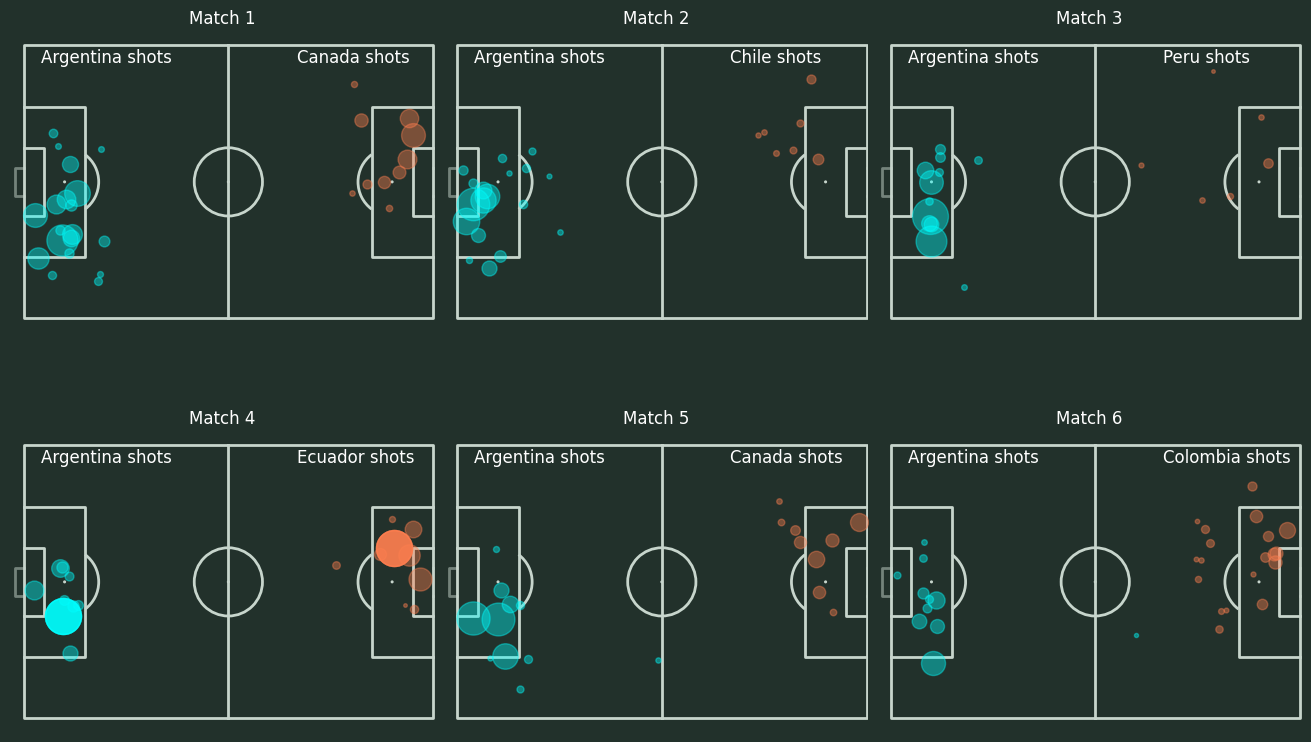

In [37]:
argentina_players = ("Emiliano Martínez", "Franco Armani", "Gerónimo Rulli",
                    "Gonzalo Montiel", "Nahuel Molina", "Leonardo Balerdi", "Cristian Romero",
                    "Germán Pezzella", "Nicolás Otamendi", "Lisandro Martínez", "Marcos Acuña",
                    "Nicolás Tagliafico", "Guido Rodríguez", "Leandro Paredes", "Alexis Mac Allister",
                    "Rodrigo De Paul", "Exequiel Palacios", "Enzo Fernández", "Giovani Lo Celso",
                    "Lionel Messi", "Ángel Di María", "Alejandro Garnacho", "Valentín Carboni",
                    "Nicolás González", "Lautaro Martínez", "Julián Álvarez")

rivals = ('Canada', 'Chile', 'Peru', 'Ecuador', 'Canada', 'Colombia')

def generateCombinedShotmaps(ax, shotmap_df, f_argentinaplayers, rival, match_number):
    # create pitch
    pitch = Pitch(
        pad_right=0.5,
        pitch_type='statsbomb', 
        line_color='#c7d5cc',
        pitch_color='#22312b',
        goal_alpha=0.5,
        goal_type='box',
    )
    
    pitch.draw(ax=ax)
    
    # scatter the shots
    for _, row in shotmap_df.iterrows():
        coordinate_to_dict = ast.literal_eval(row['Player Coordinates'])
        x = coordinate_to_dict['x']
        y = coordinate_to_dict['y']
        if row.Name in f_argentinaplayers:
            pitch.scatter(x, y, s=row['Expected Goal (xG)']*850, c='cyan', marker='o', alpha=0.4, ax=ax)
        else:
            pitch.scatter(120-x, 80-y, s=row['Expected Goal (xG)']*850, c='coral', marker='o', alpha=0.4, ax=ax)

    ax.text(5, 5, 'Argentina shots', color='white', size=12)
    ax.text(80, 5, rival+' shots', color='white', size=12)
    ax.set_title(f'Match {match_number}' , color='white')

# Define the number of rows and columns
n_rows = 2
n_cols = 3

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 8), constrained_layout=True)
fig.patch.set_facecolor('#22312b')

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate each shot map
for i in range(len(axes)):
    generateCombinedShotmaps(axes[i], shotmaps_tup[i], argentina_players, rivals[i], i+1)

# Hide any unused subplots 
for j in range(len(shotmaps_tup), len(axes)):
    axes[j].axis('off')

plt.show()


In [40]:
# Generate lists of x and y values for shots positions
def lists_x_y(f_argentina_shotmap):
    x_list = []
    y_list = []
    for _, row in f_argentina_shotmap.iterrows():
        coordinate_to_dict = ast.literal_eval(row['Player Coordinates'])
        x = coordinate_to_dict['x']
        y = coordinate_to_dict['y']
        x_list.append(x)
        y_list.append(y)

    return x_list, y_list

In [41]:
x_coords, y_coords = lists_x_y(shotmap_argentina)
x_coords_array = np.array(x_coords)
y_coords_array = np.array(y_coords)
std_dev_x = np.std(x_coords_array)
std_dev_y = np.std(y_coords_array)
print(f"x: {std_dev_x}\ny: {std_dev_y}")

x: 9.88782537400308
y: 11.051524734375139


In [48]:
# Building a frecuency table

# Sturges rule to find number of bins to use in histogram
C = 1 + 3.3 * math.log10(len(x_coords))

# amplitude
A = (max(x_coords) - min(x_coords)) / C

# frecuency table
intervals = []
frequencies = []
relative_frecuency = []
percentages = []
for i in range(9):
    lower_bound = min(x_coords) + i*A
    upper_bound = lower_bound + A
    interval = f"{round(lower_bound, 2)} - {round(upper_bound, 2)}"
    intervals.append(interval)

    fi = sum(lower_bound <= x < upper_bound for x in x_coords)
    frequencies.append(fi)
    relative_frecuency.append(f"{fi} / {len(x_coords)}")
    percentages.append(round((fi / len(x_coords) * 100), 1))

df_x = pd.DataFrame({
    'i': list(range(9)),
    'interval': intervals,
    'fi': frequencies,
    'pi': relative_frecuency,
    '%': percentages
})

df_x[['inicio', 'fin']] = df_x['interval'].str.split(' - ', expand=True)
df_x['inicio'] = df_x['inicio'].astype(float)
df_x['fin'] = df_x['fin'].astype(float)
df_x['marca de clase'] = (df_x['inicio'] + df_x['fin']) / 2
df_x

# Sturges rule to find number of bins to use in histogram
C = 1 + 3.3 * math.log10(len(y_coords))

# amplitude
A = (max(y_coords) - min(y_coords)) / C

# frecuency table
intervals = []
frequencies = []
relative_frecuency = []
percentages = []
for i in range(9):
    lower_bound = min(y_coords) + i*A
    upper_bound = lower_bound + A
    interval = f"{round(lower_bound, 2)} - {round(upper_bound, 2)}"
    intervals.append(interval)

    fi = sum(lower_bound <= y < upper_bound for y in y_coords)
    frequencies.append(fi)
    relative_frecuency.append(f"{fi} / {len(y_coords)}")
    percentages.append(round((fi / len(y_coords) * 100), 1))

df_y = pd.DataFrame({
    'i': list(range(9)),
    'interval': intervals,
    'fi': frequencies,
    'pi': relative_frecuency,
    '%': percentages
})

df_y[['inicio', 'fin']] = df_y['interval'].str.split(' - ', expand=True)
df_y['inicio'] = df_y['inicio'].astype(float)
df_y['fin'] = df_y['fin'].astype(float)
df_y['marca de clase'] = (df_y['inicio'] + df_y['fin']) / 2
print(df_x.head())
print(df_y.head())

   i       interval  fi        pi     %  inicio    fin  marca de clase
0  0    1.7 - 10.38  44  44 / 139  31.7    1.70  10.38           6.040
1  1  10.38 - 19.07  54  54 / 139  38.8   10.38  19.07          14.725
2  2  19.07 - 27.75  28  28 / 139  20.1   19.07  27.75          23.410
3  3  27.75 - 36.44  10  10 / 139   7.2   27.75  36.44          32.095
4  4  36.44 - 45.12   0   0 / 139   0.0   36.44  45.12          40.780
   i       interval  fi        pi     %  inicio    fin  marca de clase
0  0   25.7 - 31.49   9   9 / 139   6.5   25.70  31.49          28.595
1  1  31.49 - 37.27  21  21 / 139  15.1   31.49  37.27          34.380
2  2  37.27 - 43.06  15  15 / 139  10.8   37.27  43.06          40.165
3  3  43.06 - 48.84  33  33 / 139  23.7   43.06  48.84          45.950
4  4  48.84 - 54.63  19  19 / 139  13.7   48.84  54.63          51.735


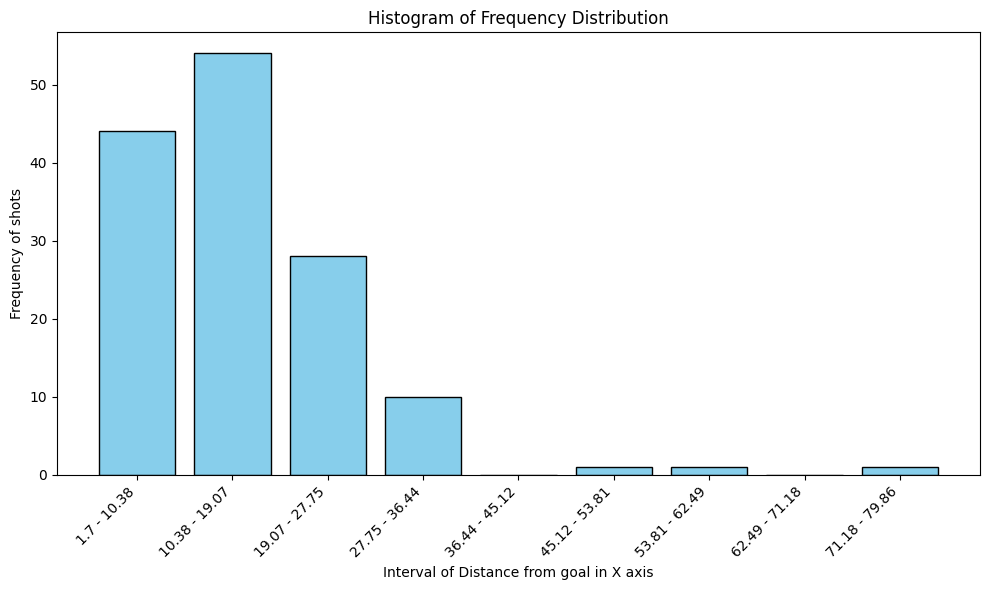

In [49]:
intervals = df_x['interval']
frequencies = df_x['fi']

plt.figure(figsize=(10, 6))
plt.bar(intervals, frequencies, width=0.8, color='skyblue', edgecolor='black')

plt.xlabel('Interval of Distance from goal in X axis')
plt.ylabel('Frequency of shots')
plt.title('Histogram of Frequency Distribution')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

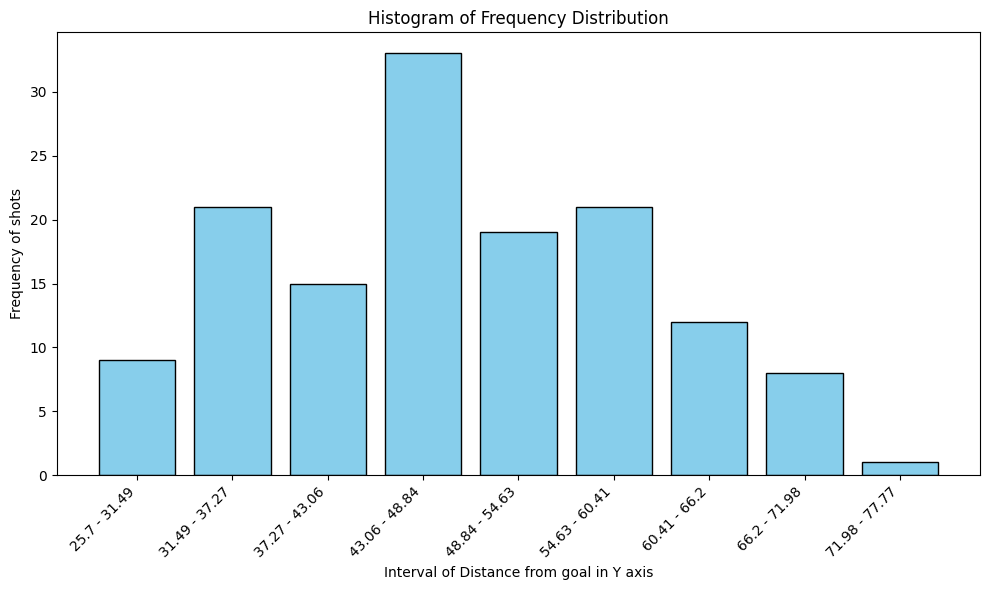

In [50]:
intervals = df_y['interval']
frequencies = df_y['fi']

plt.figure(figsize=(10, 6))
plt.bar(intervals, frequencies, width=0.8, color='skyblue', edgecolor='black')

plt.xlabel('Interval of Distance from goal in Y axis')
plt.ylabel('Frequency of shots')
plt.title('Histogram of Frequency Distribution')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### General Observations:
1. **Consistent Offensive Pressure**: Argentina appears to generate many shots from inside the penalty box across all matches, often in central positions close to the goal. These locations generally have a higher xG, indicating that Argentina is creating high-quality chances.
   
2. **Effective Chance Creation**: In most of the matches (e.g., Match 1, 2, 3, and 4), Argentina has several large circles, meaning that they created high xG opportunities. The positioning of these shots suggests they are getting into dangerous positions, which is a sign of strong attacking play.

3. **Defensive Stability**:
   - In most matches, Argentina's opponents have fewer or smaller circles in terms of xG, indicating that Argentina's defense limited their opponents to lower-quality chances. For instance, in Match 2 and 3 (against Chile and Peru), the opposing teams generated few large opportunities.
   - In contrast, in Match 1 (Canada) and Match 4 (Ecuador), the opposing teams have larger circles close to Argentina's goal, implying that the defense allowed some high-xG chances.

#### Conclusion
Argentina’s performance in the tournament was marked by strong attacking output, as evidenced by consistent high-xG opportunities across all matches. Defensively, they were generally solid, restricting most opponents to low-xG shots, though in a couple of matches (notably against Canada and Ecuador), they allowed more significant chances. This balance of strong offense and solid defense underlines their dominance in most matches, though there may be some areas of concern regarding defensive vulnerabilities in a few games.

This analysis highlights Argentina's effective chance creation, with room for potential improvement in defensive organization in certain high-xG scenarios faced against stronger attacking teams.

In [19]:
total_shots = all_stats[(all_stats['Period'] == 'Full Match') & 
             (all_stats['Statistic'] == 'Total shots') &
            (all_stats['Group'] == 'Shots')]
total_shots.dtypes

Period       object
Group        object
Statistic    object
Home         object
Away         object
Match        object
dtype: object

#### Cumulative expected goals (xG) per match: Visualization

In [32]:
# Filter out xG values from penalties
shotmap_argentina = all_shotmaps[all_shotmaps['Situation'] != 'shootout']
xg_by_match = shotmap_argentina.groupby('Match')['Expected Goal (xG)'].sum().reset_index()
goals_by_match = shotmap_argentina[shotmap_argentina['Outcome'] == 'goal'].groupby('Match').size().reset_index(name='Goals')
# Merge xG and goals by match
xg_by_match = pd.merge(xg_by_match, goals_by_match, on='Match', how='left')
xg_by_match['Goals'] = xg_by_match['Goals'].fillna(0).astype(int)
xg_by_match

,Match,Expected Goal (xG),Goals
0,Match 1,4.242149,2
1,Match 2,2.907928,1
2,Match 3,2.539513,2
3,Match 4,2.622622,2
4,Match 5,2.982967,2
5,Match 6,2.064564,1


In [33]:
goals_by_shots = bc_scored_sum / total_shots_sum
rate_bc_target = bc_scored_sum / shots_onTarget_sum * 100
xG_vs_goals = bc_scored_sum / xG_arg_sum
bc_efficiency = bc_scored_sum / (bc_scored_sum + bc_missed_sum)

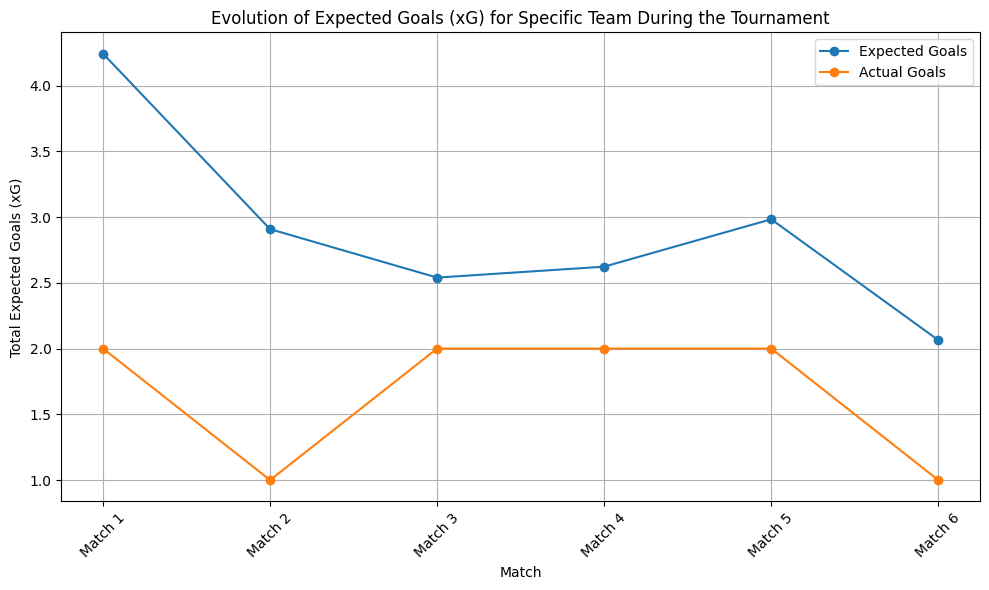

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(xg_by_match['Match'], xg_by_match['Expected Goal (xG)'], marker='o', linestyle='-', label='Expected Goals')
plt.plot(xg_by_match['Match'], xg_by_match['Goals'], marker='o', linestyle='-', label='Actual Goals')
plt.title('Evolution of Expected Goals (xG) for Specific Team During the Tournament')
plt.xlabel('Match')
plt.ylabel('Total Expected Goals (xG)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

From the visualization of Argentina’s expected goals (xG) vs actual goals throughout the tournament, the following conclusions can be made:

### 1. **Underperformance in Finishing**
   - In every match, Argentina’s expected goals (xG) exceeded their actual goals, meaning they created more high-quality chances than they were able to convert into goals. This consistent gap suggests inefficiency in finishing.
   - Notably, in **Match 1**, the xG was particularly high (above 4), but Argentina scored much fewer goals. This indicates missed opportunities, possibly big chances that were not converted.

### 2. **Declining xG Trend**
   - After **Match 1**, there is a visible decline in xG, with some stabilization around **Match 3 and 4**, and a small increase in **Match 5** before dipping again in **Match 6**. This trend suggests that Argentina was creating fewer quality chances as the tournament progressed.
   - This could indicate a tactical shift, stronger opponents, or fatigue, leading to fewer clear-cut opportunities.

### 3. **Low Conversion Rate Despite Consistent xG**
   - Argentina maintained a relatively stable xG from **Match 3 to Match 6**, which indicates they were still creating chances. However, their actual goal tally remained low and consistent across most matches (around 1-2 goals), emphasizing their difficulty in converting chances into goals.

### Conclusion:
   - **Argentina created opportunities throughout the tournament, as reflected by their xG, but they were inefficient in turning those chances into goals.** This inefficiency in finishing may have cost them in crucial moments, and addressing this could be key for improving their performance in future tournaments. Additionally, the declining xG trend suggests they struggled to maintain the same attacking threat as the tournament went on, likely due to various factors such as opposition strength or fatigue.

#### Do high expected goal (xG) values typically result in actual goals?

In [29]:
all_shotmaps['Expected Goal (xG)'] = pd.to_numeric(all_shotmaps['Expected Goal (xG)'], errors='coerce')
filtered_data = all_shotmaps[['Outcome', 'Expected Goal (xG)']].dropna()
filtered_data.head()

,Outcome,Expected Goal (xG)
0,save,0.071207
1,save,0.023184
2,goal,0.594084
3,miss,0.345816
4,save,0.401235


C:\Users\diego\AppData\Local\Temp\ipykernel_40244\964037511.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y='Expected Goal (xG)', data=filtered_data, order=['goal', 'save', 'miss'], palette=palette)


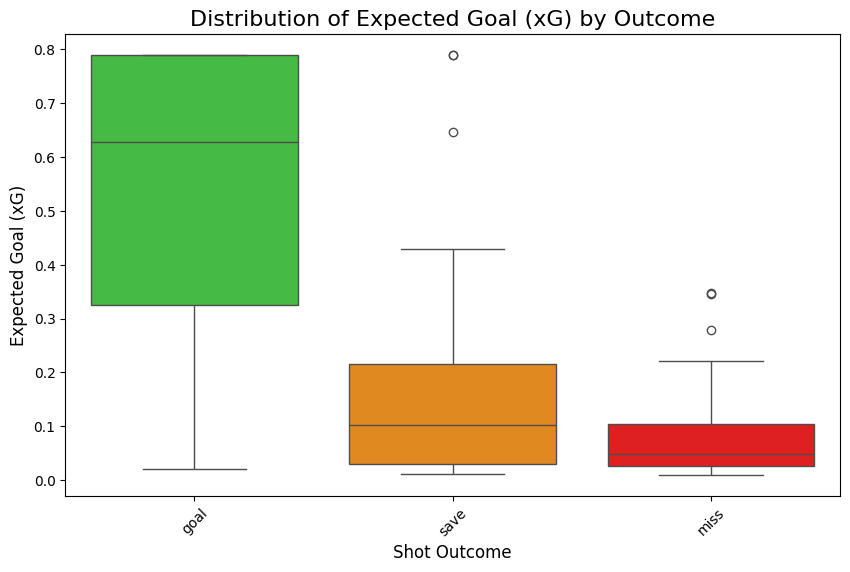

In [30]:
palette = {'goal': 'limegreen', 'save': 'darkorange', 'miss': 'red'}

plt.figure(figsize=(10, 6))
sns.boxplot(x='Outcome', y='Expected Goal (xG)', data=filtered_data, order=['goal', 'save', 'miss'], palette=palette)
plt.title('Distribution of Expected Goal (xG) by Outcome', fontsize=16)
plt.ylabel('Expected Goal (xG)', fontsize=12)
plt.xlabel('Shot Outcome', fontsize=12)
plt.xticks(rotation=45)
plt.show()

From the box plot analysis, we can conclude that **higher expected goal (xG) values do generally result in actual goals.**

- The shots that resulted in **goals** have the highest median and upper range of xG values, with many of them being around or above **0.5**. This indicates that higher xG shots (which are statistically more likely to be scored) tend to convert into goals more often.
  
- In contrast, shots that were **saved** or **missed** typically have lower xG values. The median xG for saved shots is lower (around **0.3**), and for missed shots, it's even lower (around **0.1**). This suggests that lower xG values are less likely to lead to goals.

Thus, while high xG values don't guarantee a goal, they are significantly more likely to result in goals based on the data shown in the box plots.

#### Some feature engineering

In [36]:
# Total Shots
total_shots.loc[:, 'Home'] = pd.to_numeric(total_shots['Home'])
total_shots.loc[:, 'Away'] = pd.to_numeric(total_shots['Away'])
home_sum = total_shots.drop(index=133)['Home'].sum()
total_shots_sum = home_sum + total_shots.loc[133, 'Away']

# Shots on Target
shots_on_target = all_stats[(all_stats['Period'] == 'Full Match') & 
             (all_stats['Statistic'] == 'Shots on target') &
            (all_stats['Group'] == 'Shots')]
shots_on_target.loc[:, 'Home'] = pd.to_numeric(shots_on_target['Home'])
shots_on_target.loc[:, 'Away'] = pd.to_numeric(shots_on_target['Away'])
home_sum = 0
home_sum = shots_on_target.drop(index=134)['Home'].sum()
shots_onTarget_sum = home_sum + shots_on_target.loc[134, 'Away']

# Expected goals (xG)
expected_goals = all_stats[(all_stats['Period'] == 'Full Match') &
                            (all_stats['Statistic'] == 'Expected goals')]
expected_goals.loc[:, 'Home'] = pd.to_numeric(expected_goals['Home'])
expected_goals.loc[:, 'Away'] = pd.to_numeric(expected_goals['Away'])
xG_arg_sum = expected_goals.drop(index=123)['Home'].sum()
xG_arg_sum += expected_goals.loc[123, 'Away']

# Big Chances Scored and Big Chances Missed
big_chances_scored = all_stats[(all_stats['Period'] == 'Full Match') &
                            (all_stats['Statistic'] == 'Big chances scored') &
                            (all_stats['Group'] == 'Attack')]
big_chances_scored.loc[:, 'Home'] = pd.to_numeric(big_chances_scored['Home'])
big_chances_scored.loc[:, 'Away'] = pd.to_numeric(big_chances_scored['Away'])
bc_scored_sum = big_chances_scored.drop(index=140)['Home'].sum()
bc_scored_sum += big_chances_scored.loc[140, 'Away']

big_chances_missed = all_stats[(all_stats['Period'] == 'Full Match') & (all_stats['Statistic'] == 'Big chances missed') &
                                (all_stats['Group'] == 'Attack')]
big_chances_missed.loc[:, 'Home'] = pd.to_numeric(big_chances_missed['Home'])
big_chances_missed.loc[:, 'Away'] = pd.to_numeric(big_chances_missed['Away'])
bc_missed_sum = big_chances_missed.drop(index=141)['Home'].sum()
bc_missed_sum += big_chances_missed.loc[141, 'Away']


### Conclusions and Future Research Ideas

#### Conclusions:
1. **Attacking Efficiency:**
   - Argentina produced a significant number of shots and created numerous high-quality chances (reflected by their xG). However, they underperformed in terms of goal conversion, suggesting inefficiency in front of goal. Improving finishing will be key to enhancing their overall performance.
   
2. **Big Chance Conversion:**
   - The analysis highlighted Argentina's struggles with converting clear-cut opportunities (big chances). Despite creating these valuable chances, their conversion rate indicates a need for sharper finishing in critical moments of play.
   
3. **Consistency in Performance:**
   - While Argentina consistently created scoring opportunities across matches, their inability to capitalize on these at a higher rate limited their goal-scoring output. Addressing this gap between chance creation and execution will be vital for future success.

#### Future Research Ideas:
1. **Player-Specific Analysis:**
   - Future studies could delve into individual player performance, focusing on key attacking players and their contributions to overall team efficiency, shot quality, and finishing ability. This could help identify areas for targeted improvement.
   
2. **Comparison with Other Teams:**
   - Comparing Argentina’s offensive efficiency with other top teams could provide further insights into whether their conversion rates are below average or in line with competitive benchmarks.
   
3. **Contextual Analysis:**
   - Investigating how Argentina's performance changes under different match conditions (e.g., against stronger vs. weaker opponents, home vs. away matches, or during high-pressure situations like finals) could provide more nuanced insights into their efficiency.
   
4. **Defensive Analysis:**
   - Extending the analysis to Argentina’s defensive capabilities, including how many chances they concede, could offer a more balanced view of their overall performance, not just offensively but in terms of preventing goals as well.
